In [12]:
from scipy.fftpack import fft, ifft, fftshift
from scipy import conj, linspace, exp
from scipy.constants import pi
from matplotlib import pyplot as plt
import numpy as np
from numpy import zeros, sqrt, conj

from scipy.constants import pi, c
import torch

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [1]:
def generate_waveform(bandwidth, pulse_duration, n_pulses, t, wait_time):
    
    k = bandwidth / pulse_duration
    pulses = []
    wait = torch.zeros((wait_time))
    for n in range (n_pulses):
        pulse = torch.exp(1j * pi * k * torch.pow(t - pulse_duration/2, 2))
        pulses.append(torch.cat([pulse, wait]))
    lfm = torch.cat(pulses).reshape(n_pulses, -1)
    return lfm

In [2]:
def doppler_processing(signal, data,  nfft_range, nfft_doppler):
    # TODO: ADD WINDOWING
    
    range_scaling = torch.sqrt(torch.Tensor([nfft_range]))
    doppler_scaling = torch.tensor(data.shape[-2], dtype=torch.complex64)
    
    kernel = torch.conj(torch.fft.fft(signal, n = nfft_range, dim=-1, norm='ortho'))

    rows = range_scaling * torch.fft.ifft(torch.multiply(kernel,torch.fft.fft(data, n = nfft_range,dim=-1,norm='ortho')), n=nfft_range, dim=-1, norm='ortho')

    columns = doppler_scaling * torch.fft.fft(rows, n=nfft_doppler, dim = -2, norm='ortho')

    return torch.fft.fftshift(torch.fft.fftshift(columns, dim=-2),dim=-1)

In [3]:
def make_scene(amplitudes,ranges,velocities,max_unamb_range,max_unamb_vel,nfft_range,nfft_doppler):

    # compute normalized aparent ranges and velocities (considering ambiguos range/vel)
    ranges = torch.fmod(ranges,max_unamb_range) / max_unamb_range 
    velocities = torch.fmod(velocities,max_unamb_vel) / max_unamb_vel

    # compute binnned range and velocities
    ranges = torch.round((ranges  + 1) * (nfft_range//2)).long()
    velocities = torch.round((velocities + 1) * (nfft_doppler//2)).long()
    

    # fill scene matrix
    scene = torch.zeros(1,nfft_doppler,nfft_range,dtype=torch.complex64)
    for i,(rind,vind) in enumerate(zip(ranges,velocities)):
        scene[0,vind,rind] = amplitudes[i]

    return scene

def fft(signal, nfft :int=None,dim :int=-1):
    data = signal.data
    nfft = nfft if nfft else 2 * num_samples - 1
    return torch.fft.fft(input=data,n=nfft,dim=dim,norm='ortho')

def ifft(signal,nfft :int=None,dim :int=-1):
    data = signal.data
    nfft = nfft if nfft else 2*num_samples - 1
    return torch.fft.ifft(input=data,n=nfft,dim=dim,norm='ortho')

In [5]:
def simulate_target_with_scene_profile(signal, scene_profile, num_pulses):

    # scene parameters
    nfft_doppler = scene_profile.shape[-2]
    nfft_range = scene_profile.shape[-1]

    # scaling for correcting signal amplitude
    range_fft_scaling = torch.sqrt(torch.Tensor([nfft_range]))
    doppler_fft_scaling = torch.sqrt(torch.Tensor([nfft_doppler]))

    # kernel from operation
    kernel = fft(signal,nfft=nfft_range)

    # arrange Doppler bins
    scene_profile = torch.fft.fftshift(torch.fft.fftshift(scene_profile,dim=-2),dim=-1)

    # propagate dopplers from targets and select the number of pulses
    scene_profile = ifft(scene_profile,nfft=nfft_doppler,dim=-2)[:,:num_pulses,:] * doppler_fft_scaling
    # compute fft of the range profiles of each of the pulses
    scene_profile = fft(scene_profile,nfft=nfft_range,dim=-1) * range_fft_scaling
    # apply convolution with signal kernel and go back to time domain
    scene_profile = ifft(torch.multiply(kernel,scene_profile),nfft=nfft_range,dim=-1)

    return scene_profile

In [6]:
def pulse(bandwidth, pulse_duration, num_samples, fs, delay = 0):
    
    pulse_num_samples = int(np.ceil(pulse_duration*fs))
    k = bandwidth / pulse_duration

    t = torch.linspace(0, pulse_duration, pulse_num_samples)
    
    lfm = torch.zeros((num_samples), dtype=torch.complex64)

    pulse = torch.exp(1j * pi * k * torch.pow(t - pulse_duration/2, 2))
    lfm[:len(t)] = pulse
    
    lfm = torch.roll(lfm, delay)
    return lfm

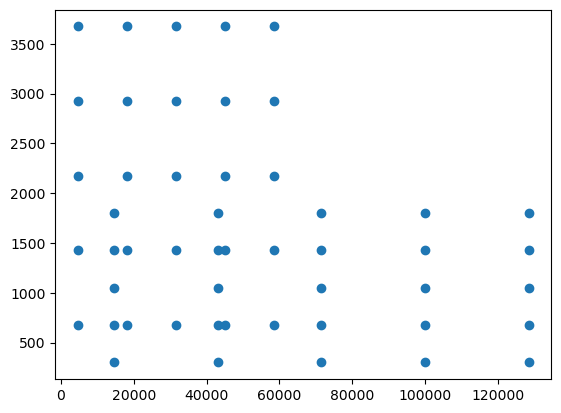

tensor([14550.0000,  1049.7406])

In [24]:
def resolve_range_ambiguity(iterations : int, apparent_ranges,  apparent_velocities,max_unamb_ranges,max_unamb_velocities):
    n_bursts = len(apparent_ranges)
    points = torch.zeros((n_bursts, iterations ** 2, 2))
                
    for n in range(0, n_bursts):
        ranges = []
        vels = []
        for i in range(0, iterations):
                r = apparent_ranges[n] + i * max_unamb_ranges[n]
                v = apparent_velocities[n] + i * max_unamb_velocities[n]
                ranges.append(r)
                vels.append(v)
                
        cart_prod = torch.cartesian_prod(torch.tensor(ranges), torch.tensor(vels))
        points[n, :] = cart_prod
    points = points.reshape(-1, 2)
    plt.scatter(points[:, 0], points[:, 1])
    plt.show()
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(points)
    distances, indices = nbrs.kneighbors(points)
    # remove itself from neighbor
    indices = indices[:, 1]
    distances = distances[:, 1]
    smallest = np.argmin(distances)
    return points[smallest]
    
# resolve_range_ambiguity(5, [14550, 4600],  [300.2594, 675],[28480.28351, 13490.66061],[374.7405725, 749.481145])

In [38]:
# input is a list of burst and a list of received signals
# output is the received signal taking into account eclipsing
# transmit time should be in samples
def merge_bursts(bursts : [torch.tensor], received : [torch.tensor], transmit_times):
    max_len = 0
    for burst in bursts:
        length = burst.shape[1] * burst.shape[2]
        if length > max_len:
            max_len = length 
    for echo in received:
        length = echo.shape[1] * echo.shape[2]
        if length > max_len:
            max_len = length 
    max_len += max(transmit_times)
    final_echo = 0

    for i, (burst, echo) in enumerate(zip(bursts, received)):
        burst = burst.reshape(-1)
        echo = echo.reshape(-1)
        
        new_len_burst = max(0, max_len - len(burst) - transmit_times[i])
        new_len_echo = max(0, max_len - len(echo) - transmit_times[i])
        bursts[i] = torch.cat([torch.zeros(transmit_times[i]), burst, torch.zeros(new_len_burst)])
        echo = torch.cat([torch.zeros(transmit_times[i]), echo, torch.zeros(new_len_echo)])
        final_echo  += echo

        
    for burst in bursts:
        mask = torch.zeros_like(burst, dtype=torch.long)
        mask[torch.abs(burst) <= 1e-8] = 1

        final_echo = final_echo * mask

    return final_echo

In [5]:
def SNR(signal, noise):
    # TODO ask mario if this is correct / take a look at matlab
    S = fft(signal)
    N = fft(noise)

    snr = 10 * torch.log10(torch.linalg.vector_norm(torch.conj(S)*S) /torch.linalg.vector_norm(torch.conj(S) * N))
    return snr

In [ ]:
# image should be doppler processed and noise already added
# output might contain NaN values
def CFAR(image, k_width, k_height, alpha=5, plot=False):
    # create kernel
    kernel = torch.ones((1,1, k_height,k_width))
    inner_width = k_width//4
    inner_height = k_height//4
    kernel[0, 0, (k_height-inner_height)//2: (k_height+inner_height)//2, (k_width-inner_width)//2: (k_width+inner_width)//2] = 0
    kernel = kernel / kernel.sum()
    
    #convolve image
    convd = torch.nn.functional.conv2d(input=image, weight=kernel, padding='valid', stride=1)
    # compare with estimated noise power
    threshold = image[0, 0, :convd.shape[2], :convd.shape[3]] > convd * alpha
    
    # some reshaping
    final_x = threshold.reshape(nfft_doppler - k_height + 1, nfft_range - k_width + 1).detach().numpy()
    final_x = np.where(final_x == True)
    final_x = np.dstack((final_x[1] * max_unamb_range * 2 / nfft_range - max_unamb_range, final_x[0] * max_unamb_vel * 2 / nfft_doppler - max_unamb_vel))[0]
    
    # clustering
    db = DBSCAN(eps=50, min_samples=10).fit(final_x)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    if plot:
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = labels == k

            xy = final_x[class_member_mask & core_samples_mask]

            plt.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=14,
            )

            xy = final_x[class_member_mask & ~core_samples_mask]
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=6,
            )

        plt.title(f"Estimated number of clusters: {n_clusters_}")
        plt.show()
    
    xs = []
    ys = []
    for k in unique_labels:
        class_member_mask = labels == k

        xy = final_x[class_member_mask & core_samples_mask]

        r = ((xy[:, 0] + max_unamb_range) * nfft_range / (2 * max_unamb_range)).astype(int)
        v = ((xy[:, 1]  + max_unamb_vel) * nfft_doppler / (2 * max_unamb_vel)).astype(int)
        powers = image[0, 0, v, r]
        x = (powers * xy[:, 0]).sum() / powers.sum()
        y = (powers * xy[:, 1]).sum() / powers.sum()
        xs.append(x.item())
        ys.append(y.item())
    if plot:
        plt.scatter(xs, ys)
        plt.show()
    return list(zip(xs, ys))